### Please keep in mind this is an initial, naive solution and is subject to drastic change.

In [30]:
from pathlib import Path
from anomalib.data.utils import read_image
from anomalib.deploy import TorchInferencer
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from anomalib.data.folder import Folder
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

### Additionally I modified the data in the following ways:
- I moved all the normal and abnomral instances into their own directories all together,
- I also removed any images with \*ref|Ref\* in their name that were in the abnormal/anomalous directories from being since they are from the refrence image, meaning they are what the client wants. You can verify this for yourselfes.
- To start you might also want to remove the images that are masked initially if you are only running this file, expect updates soon...

In [32]:
from anomalib.data.task_type import TaskType

# data_dir = Path.cwd()
data_dir=Path.cwd()/"Reels"
# print(data_dir)

data_module = Folder(
    root=data_dir,
    normal_dir="./normal/normal",
    abnormal_dir="abnormal",
    normal_split_ratio=0.1,
    image_size=(256, 256),
    train_batch_size=64,
    eval_batch_size=64,
    task=TaskType.CLASSIFICATION,
    normalization="imagenet",
    seed=44,
)
data_module.setup()
data_module.prepare_data()
i, data = next(enumerate(data_module.val_dataloader()))
print(data.keys())
print(type(data["image"]))
print(len(data_module.test_data), len(data_module.train_data), len(data_module.val_data))
data_module.train_data[0]

dict_keys(['image_path', 'label', 'image'])
<class 'torch.Tensor'>
147 731 146


{'image_path': '/home/turbouser44/juicebox/Reels/normal/normal/67_0-0.bmp',
 'label': 0,
 'image': tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 2.1975,  2.1462,  1.9064,  ...,  0.4166,  0.3994,  0.3994],
          [ 2.1975,  2.1290,  1.8379,  ..., -0.3027, -0.3369, -0.3712],
          [ 2.1975,  2.1290,  1.7865,  ..., -0.7822, -0.8335, -0.8678]],
 
         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 2.4286,  2.4111,  2.2535,  ...,  1.0455,  1.0280,  1.0105],
          [ 2.4286,  2.4111,  2.2010,  ...,  0.3452,  0.2927,  0.2752],
          [ 2.4286,  2.4111,  2.1660,  ..., -0.1275, -0.1800, -0.2150]],
 
  

In [33]:
print(data["image"].shape)

torch.Size([64, 3, 256, 256])


In [34]:
from anomalib.models import Padim

model = Padim(
    input_size=(256, 256),
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3", "layer4"]
)

FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [35]:
from anomalib.post_processing import NormalizationMethod, ThresholdMethod
from anomalib.utils.callbacks import (
    MetricsConfigurationCallback,
    MinMaxNormalizationCallback,
    PostProcessingConfigurationCallback,
)
from anomalib.utils.callbacks.export import ExportCallback, ExportMode

callbacks = [
    MetricsConfigurationCallback(
        task=TaskType.CLASSIFICATION,
        image_metrics=["AUROC"],
    ),
    ModelCheckpoint(
        every_n_epochs=10,
        monitor="image_AUROC",
    ),
    PostProcessingConfigurationCallback(
        normalization_method=NormalizationMethod.MIN_MAX,
        threshold_method=ThresholdMethod.ADAPTIVE,
    ),
    MinMaxNormalizationCallback(),
    ExportCallback(
        input_size=(256, 256),
        dirpath=str(Path.cwd()),
        filename="4layer_model.pt",
        export_mode=ExportMode.TORCH,
    ),
]

In [ ]:
trainer = Trainer(
    callbacks=callbacks,
    accelerator="auto",
    auto_scale_batch_size=False,
    check_val_every_n_epoch=4,
    devices=1,
    gpus=None,
    max_epochs=20,
    num_sanity_val_steps=0,
    val_check_interval=1.0,
)
trainer.fit(model=model, datamodule=data_module)

In [ ]:
test_results = trainer.test(model=model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00,  6.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.7121848464012146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


(166, 166, 3)

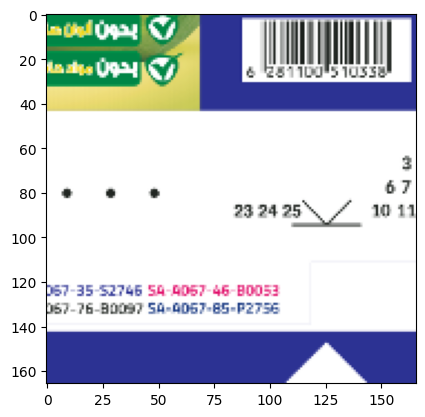

In [36]:
trainer= Trainer(resume_from_checkpoint="lightning_logs/version_9/checkpoints/epoch=39-step=1199.ckpt")
from matplotlib import pyplot as plt
norm_imagepath = data_dir/"normal/NpdfSpot_24_ref.bmp"
norm_image = read_image(norm_imagepath)
plt.imshow(norm_image)
norm_image.shape

### Loading the saved model

In [37]:
# import torch
# model = model.load_from_checkpoint(Path.cwd() / 'lightning_logs/version_6/checkpoints/epoch=3-step=36.ckpt')
# model.laod_sta
model_path = Path.cwd() / 'weights/torch/model.pt'
inferencer = TorchInferencer(path=model_path)

In [38]:
#! Predict -> returns ImageResult type
norm_predictions = inferencer.predict(image=norm_image)
# type(predictions)
# predictions
# predictions2 = inferencer.predict(norm_image=abnormal_image)

In [39]:
from anomalib.post_processing import Visualizer, VisualizationMode
from PIL import Image

# visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
# output_image = visualizer.visualize_image(norm_predictions)
# Image.fromarray(output_image)
# output_image.shape

In [43]:
from utils import split_into_patches, normalize_patches
# import anomalib.data.utils.transform as tf

visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
# pred_abnormal = inferencer.predict(image=abnormal_image)
abnormal_job_path = data_dir / 'Job1.bmp'
# print(abnormal_job_path)
abnormal_job_image_patchnormed = read_image(abnormal_job_path)
# print(type(abnormal_job_image_patchnormed))
abnormal_job_image_patchnormed = split_into_patches(abnormal_job_image_patchnormed)
# abnormal_job_image_patchnormed = normalize_patches(abnormal_job_image_patchnormed)


In [44]:
# print(type(normd_abnormal_job_image_patched[0]))
print(type(abnormal_job_image_patchnormed))
# h = read_image(normd_abnormal_job_image_patched)
# visualizer.visualize_image(norm_abnormal_job_image_patched)
# print(h.shape)
# (normd_abnormal_job_image_patched)
preds_full_print_job = []
i=0
for i in range(len(abnormal_job_image_patchnormed)):
    # abnormal_job_image_patchnormed[i] = normalize_patches(abnormal_job_image_patchnormed[i])
    preds_full_print_job.append(inferencer.predict(image=abnormal_job_image_patchnormed[i]))
    Image.fromarray(visualizer.visualize_image(preds_full_print_job[i])).save(f"printjob_patch_prediction{i}.png")
    break
    # Image.fromarray(visualizer.visualize_image(preds_full_print_job[i])).save(f"./lightning_logs/tmp_imgs/Job1_Path{i}.png")
    # Image.fromarray(visualizer.visualize_image(predsJob))
    # h = read_image(abnormal_job_image_patchnormed)

    # break
    # out_im_batch_job = visualizer.visualize_image(h)
    # if i ==40:
    #     break
# output_image = visualizer.visualize_image(normd_abnormal_job_image_patched[180])
# Image.fromarray(output_image)
# type(abnormal_job_image_patchnormed)


<class 'numpy.ndarray'>


In [23]:
from inference import infer
# inferencer
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
unseen_anomalous_preds = infer("./Reels/heldoutAnomalous")
for i in range(len(unseen_anomalous_preds)):
    Image.fromarray(visualizer.visualize_image(unseen_anomalous_preds[i])).save(f"unseen_anomalous{i}.png")
    # break

In [26]:
# Creating more data out of refrence images and adding it to the normal images dataset
from utils import split_into_patches, normalize_patches
abnormal_job_path = data_dir / 'Job1.bmp'

abnormal_job_image_patchnormed = read_image(abnormal_job_path)
abnormal_job_image_patchnormed = split_into_patches(abnormal_job_image_patchnormed)

# import os
# for _, _, f in os.walk(data_dir/"refs"):
#     print(f[0])
#     img = read_image(os.path.join(data_dir/"refs", f[0]))
#     img = split_into_patches(img)
#     for i in range(len(img)):
#         Image.fromarray(img[i]).save(data_dir/f"normal/NSynthetic_{i}.jpg")
#     print(len(f))